# Disseration Experiment FriedB
# Friedman Analysis + W Signed Test - April 2024¶
Ciaran Finnegan April 2024

This is the corrected final statistical analysis with the XAI experiment outputs as input test data.

The purpose was to correct an error in the original statistical analysis.

The 20 results from the five custom evaluation metrics in each of the four XAI technique XLs are read directly as input.

The input data is not averaged per XAI method, and the significance tests are conducted using all the sample data directly.

# Import Libraries + Custom Functions

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon

#### Suppress Warnings to clean up output

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Load Excel Data

## Extract XAI (Mean) Experiment Values from EXCEL

In [3]:
# Load the data from an Excel file
data = pd.read_excel('XAI_StatTest2_RowLables_v1.xlsx')

# Extracting the values for each XAI method
shap = data['SHAP'].values
lime = data['LIME'].values
anchors = data['ANCHOR'].values
dice = data['DiCE'].values

In [4]:
data

,Metric,SHAP,LIME,ANCHOR,DiCE
0,Identity,41.307692,4.617993,9.687500,12.846154
1,Stability,58.000000,49.773153,49.921875,56.923077
2,Seperability,97.384615,96.769231,21.562500,47.000000
3,Similairity,0.280949,0.589751,1.627172,15.997687
4,Comp_Efficiency,390.281732,738.144645,2832.940816,85.974151


## Load Full Experiment Data from XL

#### Set file path for input data from each XAI technique experiment

In [5]:
# Filenames of the spreadsheets for each XAI technique
filepaths = {
    "SHAP": "SHAP_XAI_Metrics_Experiments Formatted cf v1-1 250324.xlsx",
    "LIME": "LIME_XAI_Metrics_Experiments Formatted cf v1-1 250324.xlsx",
    "ANCHORS": "ANCHOR_XAI_Metrics_Experiments Formatted cf v1-1 250324.xlsx",
    "DiCE": "DiCE_XAI_Metrics_Experiments Formatted cf v1-1 250324.xlsx",
}

In [6]:
# Load each spreadsheet into a dataframe
dataframes = {technique: pd.read_excel(filepath) for technique, filepath in filepaths.items()}

In [7]:
# Display the first few rows of one of the dataframes to understand its structure
dataframes["SHAP"].head()

,Sample Number,XAI_Identity,XAI_Stability,XAI_Seperability,XAI_Similairity,Comp_Efficiency
0,1,40.000000,87.692308,96.923077,0.274628,384.508690
1,2,46.153846,76.923077,96.923077,0.231959,386.190979
2,3,49.230769,67.692308,90.769231,0.207120,384.938421
3,4,36.923077,75.384615,93.846154,0.263651,386.692740
4,5,47.692308,83.076923,100.000000,0.280038,384.335014


# Friedman Analysis

## Perform Friedman Test

In [8]:
# Prepare the data: Extract the evaluation metrics columns from each dataframe
metrics_columns = ["XAI_Identity", "XAI_Stability", "XAI_Seperability", "XAI_Similairity", "Comp_Efficiency"]
data_prepared = {technique: df[metrics_columns] for technique, df in dataframes.items()}

In [9]:
# Check if all dataframes have the same shape, ensuring a matched set of observations
all_same_shape = all(df.shape == list(data_prepared.values())[0].shape for df in data_prepared.values())

if not all_same_shape:
    raise ValueError("Dataframes have differing shapes, indicating unmatched sets of observations.")

In [10]:
# Conduct the Friedman test for each evaluation metric
friedman_results = {}

for metric in metrics_columns:
    
    # Extract the corresponding metric across all techniques for the Friedman test
    data_for_test = [df[metric] for df in data_prepared.values()]
    
    # Perform the Friedman test
    stat, p_value = friedmanchisquare(*data_for_test)
    
    # Store results
    friedman_results[metric] = {
        "Statistic": stat, 
        "p-Value": p_value,
        'Significant Difference': 'Yes' if p_value < 0.05 else 'No'
    }

In [11]:
# Convert the Friedman test results into a dataframe for display
friedman_results_df = pd.DataFrame(friedman_results).T

## Present Friedman Analysis

In [12]:
friedman_results_df

,Statistic,p-Value,Significant Difference
XAI_Identity,47.76,0.0,Yes
XAI_Stability,1.56,0.668493,No
XAI_Seperability,55.4,0.0,Yes
XAI_Similairity,60.0,0.0,Yes
Comp_Efficiency,60.0,0.0,Yes


# Plot Analysis

## Generate Plots

### Bar Charts 

Create bar charts for each metric, showing the average score for each XAI technique. This will help illustrate the differences in performance across the techniques for the metrics where significant differences were identified.

In [13]:
# Set the style of the seaborn
sns.set(style="whitegrid")

In [14]:
# Filter out the metrics with significant differences for visualization
significant_metrics = friedman_results_df[friedman_results_df['Significant Difference'] == 'Yes'].index.tolist()

In [15]:
# Display the custom metrics that show significance in their differences
significant_metrics

['XAI_Identity', 'XAI_Seperability', 'XAI_Similairity', 'Comp_Efficiency']

#### Display Friedman Results

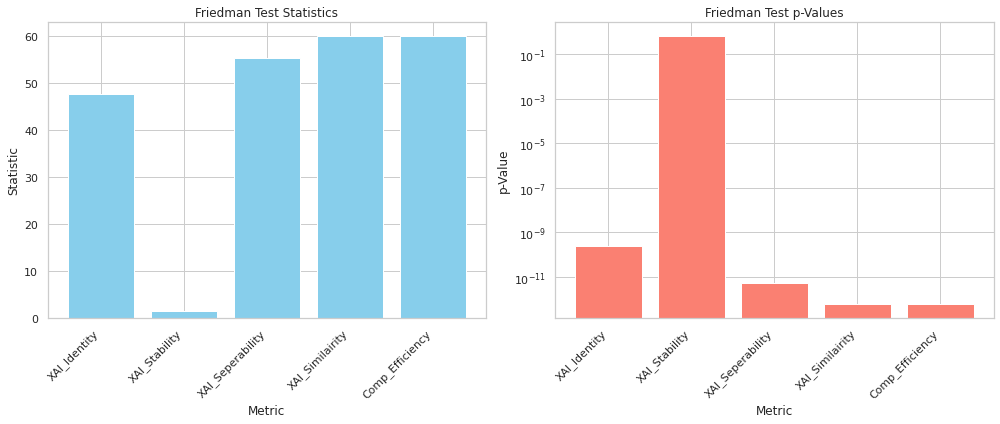

In [16]:
# Data from the Friedman analysis results to plot
metrics = friedman_results_df.index.tolist()
statistics = friedman_results_df['Statistic'].tolist()
p_values = friedman_results_df['p-Value'].tolist()

# Create bar chart for Friedman statistics
plt.figure(figsize=(14, 6))

# Bar chart for statistics
plt.subplot(1, 2, 1)
plt.bar(metrics, statistics, color='skyblue')
plt.title('Friedman Test Statistics')
plt.xlabel('Metric')
plt.ylabel('Statistic')
plt.xticks(rotation=45, ha='right')

# Bar chart for p-values
plt.subplot(1, 2, 2)
plt.bar(metrics, p_values, color='salmon')
plt.title('Friedman Test p-Values')
plt.xlabel('Metric')
plt.ylabel('p-Value')
plt.yscale('log')  # Use logarithmic scale for better visualization of p-values
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Display Metrics Scores

In [17]:
# Assuming 'data_prepared' is a dictionary with technique names as keys and dataframes as values
# We'll exclude 'XAI_Stability' from the metrics to be plotted
metrics_columns_excluding_stability = [metric for metric in metrics_columns if metric != "XAI_Stability"]
mean_scores = {metric: [] for metric in metrics_columns_excluding_stability}
techniques = list(data_prepared.keys())

In [18]:
# Set colours on graph
colors = {'SHAP': '#377eb8', 'LIME': '#ffbf00', 'ANCHORS': '#4daf4a', 'DiCE': '#e41a1c'}

In [19]:
# Prepare Bar Graph Data
for metric in metrics_columns_excluding_stability:
    for technique in techniques:
        mean_score = data_prepared[technique][metric].mean()
        mean_scores[metric].append(mean_score)

In [20]:
# Convert the mean scores to a DataFrame for easier plotting
mean_scores_df = pd.DataFrame(mean_scores, index=techniques)

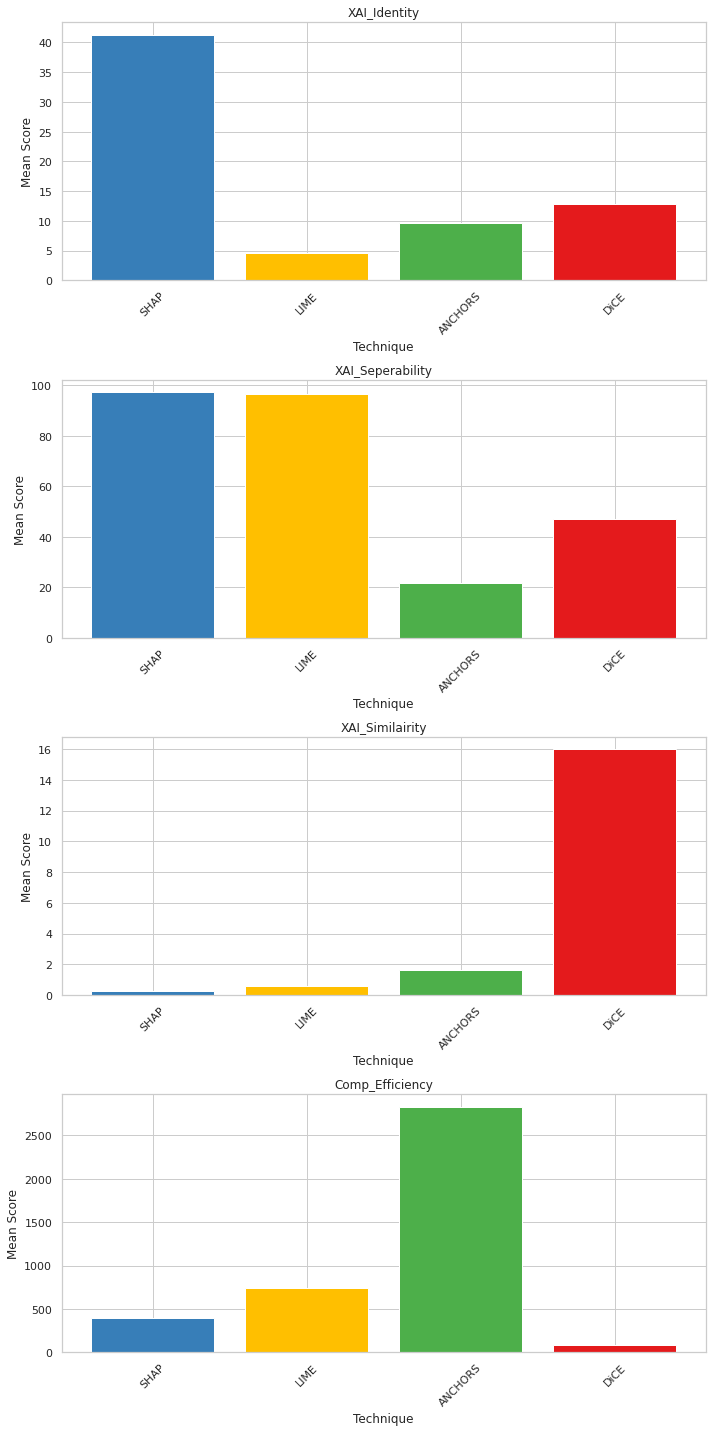

In [21]:
# Plotting
num_metrics = len(metrics_columns_excluding_stability)
fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(10, 5*num_metrics))

if num_metrics == 1:  # Adjust if there's only one metric to plot, to handle axes indexing
    axes = [axes]

for i, metric in enumerate(metrics_columns_excluding_stability):
    bar_colors = [colors[technique] for technique in mean_scores_df.index]
    axes[i].bar(mean_scores_df.index, mean_scores_df[metric], color=bar_colors)
    axes[i].set_title(metric)
    axes[i].set_xlabel('Technique')
    axes[i].set_ylabel('Mean Score')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
# This code will generate bar charts with the specified colors for each technique, arranged one on top of the other instead of side by side, 
# and with an increased graph size.

# Wilcoxon Signed-Rank Test Analysis

The Wilcoxon signed-rank test is a non-parametric test used to compare two related samples to assess whether their population mean ranks differ. 
It's an alternative to the paired t-test when the data cannot be assumed to be normally distributed.

## Implement Wilcoxon Analysis

In [22]:
# List of XAI techniques for pairwise comparison
xai_techniques = list(data_prepared.keys())

In [23]:
# Select "XAI" metrics for this analysis
xai_metrics = ["XAI_Identity", "XAI_Stability", "XAI_Seperability", "XAI_Similairity", "Comp_Efficiency"]

In [24]:
# Initialize a structure to hold the Wilcoxon signed-rank test results
wilcoxon_results = []

In [25]:
# Bonferroni correction factor
num_comparisons = len(list(itertools.combinations(xai_techniques, 2))) * len(xai_metrics)
alpha = 0.05 / num_comparisons

In [26]:
# Perform Wilcoxon signed-rank test for all pairwise comparisons and for each "XAI" metric
for metric in xai_metrics:
    for pair in itertools.combinations(xai_techniques, 2):
        data1 = data_prepared[pair[0]][metric]
        data2 = data_prepared[pair[1]][metric]
        stat, p = wilcoxon(data1, data2)
        wilcoxon_results.append({
            "Metric": metric,
            "Comparison": f"{pair[0]} vs {pair[1]}",
            "Statistic": stat,
            "p-Value": p,
            "Significant (α=0.05, Bonferroni corrected)": "Yes" if p < alpha else "No"
        })

## Present Wilcoxon Analysis

In [27]:
# Convert the Wilcoxon signed-rank test results into a dataframe for display
wilcoxon_results_df = pd.DataFrame(wilcoxon_results)

In [28]:
wilcoxon_results_df

,Metric,Comparison,Statistic,p-Value,"Significant (α=0.05, Bonferroni corrected)"
0,XAI_Identity,SHAP vs LIME,0.0,0.000002,Yes
1,XAI_Identity,SHAP vs ANCHORS,0.0,0.000002,Yes
2,XAI_Identity,SHAP vs DiCE,0.0,0.000002,Yes
3,XAI_Identity,LIME vs ANCHORS,25.0,0.001690,No
4,XAI_Identity,LIME vs DiCE,9.0,0.000063,Yes
5,XAI_Identity,ANCHORS vs DiCE,62.0,0.113987,No
6,XAI_Stability,SHAP vs LIME,76.0,0.294252,No
7,XAI_Stability,SHAP vs ANCHORS,81.0,0.388376,No
8,XAI_Stability,SHAP vs DiCE,105.0,1.000000,No
9,XAI_Stability,LIME vs ANCHORS,103.0,0.956329,No


# Supplementary Graphs

## Box Plot

In [29]:
# Load the data from an Excel file
data = pd.read_excel('XAI_StatTest2_RowLables_v1.xlsx')

In [30]:
# Extracting the values for each XAI method
shap = data['SHAP'].values
lime = data['LIME'].values
anchors = data['ANCHOR'].values
dice = data['DiCE'].values

In [31]:
# Reshape the data for plotting
reshaped_data = pd.melt(data, id_vars=['Metric'], value_vars=['SHAP', 'LIME', 'ANCHOR', 'DiCE'],
                        var_name='Method', value_name='Score')

In [32]:
box_colors = {'SHAP': '#377eb8', 'LIME': '#ffbf00', 'ANCHOR': '#4daf4a', 'DiCE': '#e41a1c'}

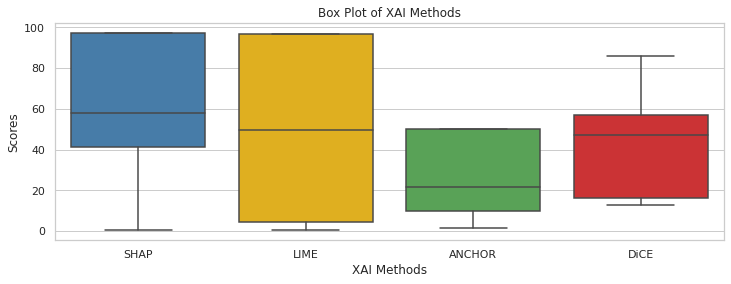

In [33]:
# Creating and displaying a Box Plot
plt.figure(figsize=(12, 4)) # Adjust the figure size as needed
sns.boxplot(x='Method', y='Score', data=reshaped_data, showfliers=False, palette=box_colors)
plt.title('Box Plot of XAI Methods')
plt.ylabel('Scores')
plt.xlabel('XAI Methods')
plt.show() # Display the first plot